# SC1015 DSAI Mini Project
## Part 3: Model 1 and 2
---
In this section we will perform model training on the top 5 variables from our cleaned dataset. We will be using K-fold cross validation in order to give us more insight to how we can train our decision tree best. We then subsequently progressed to using Random Forest, our second model and used K-Fold Cross Validation to enable us to tune our parameters to improve our model.

**Question:** Can we detect phishing websites from benign ones using their respective URLs?

## Table of Contents:
1. [Attempt 1: Decision Tree](#1\.-Attempt-1:-Decision-Tree)
2. [Feature Selection](#2\.-Feature-Selection)
3. [Attempt 1: Decision Tree Conclusion](#3\.-Attempt-1:-Decision-Tree-Conclusion)
4. [Attempt 2: Random Forest Classifier](#4\.-Attempt-2:-Random-Forest-Classifier)
5. [Parameter tuning using Cross-Validation(Randomized Search)](#5\.-Parameter-tuning-using-Cross-Validation(Randomized-Search))
6. [Attempt 2: Random Forest Conclusion](#6\.-Attempt-2:-Random-Forest-Conclusion)

In [1]:
import numpy as np

import pandas as pd# Import cleaned dataset

import seaborn as sb
sb.set(font_scale=2) # set the default Seaborn style for graphics
import matplotlib.pyplot as plt # we only need pyplot

# For model training
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv("cleaned_data.csv",index_col=0)
df.shape
df.head()

,url,phish,use_of_ip,short_url,uses-https,uses-http,count.,count@,count_dir,count_embed_domain,count%,count?,count-,count=,url_length,hostname_length,count-digits,count-letters,url_entropy
0,https://obmen.click/,phishing,not IP,original,https,http,1,0,1,0,0,0,0,0,20,11,0,15,3.884184
1,https://neueinrichtung-sparkasse.de/,phishing,not IP,original,https,http,1,0,1,0,0,0,1,0,36,27,0,30,3.995907
2,https://3db32516c1b476e7eff40e2d8ff8d9d7.krokl...,phishing,not IP,original,https,http,3,0,5,0,0,0,0,0,100,45,36,53,4.711532
3,https://f0d89a41642e0026589577e0e13d9d58.krokl...,phishing,not IP,original,https,http,3,0,5,0,0,0,0,0,100,45,42,47,4.743081
4,https://ratnes.com/,phishing,not IP,original,https,http,1,0,1,0,0,0,0,0,19,10,0,14,3.642150


In [3]:
df.isnull().values.any()

False

### 1. Attempt 1: Decision Tree

We will use K fold cross cross validation in order to explore how our different variables perform individually to predict whether a URL is phishing or benign

In [4]:
def auto_kfold_decision_tree(variables):
    # Init list to record scores
    scores = {}
    
    # Response
    df_res = df['phish']
    
    # Train for every variable
    for variable in variables:
        if variable.dtype == (np.dtype('int64') or np.dtype('float64')):
            # Numeric variable
            data_cat = pd.DataFrame(variable)
            data_ohe = pd.concat([data_cat, df_res], sort = False, axis = 1).reindex(index=data_cat.index)
        elif variable.dtype == np.dtype('object'):
            # Categorical variables
            # Import the encoder from sklearn
            ohe = OneHotEncoder()
            # OneHotEncoding of categorical predictors (not the response)
            data_cat = pd.DataFrame(variable)

            ohe.fit(data_cat)
            data_cat_ohe = pd.DataFrame(ohe.transform(data_cat).toarray(), columns=ohe.get_feature_names_out(data_cat.columns))
            
            data_ohe = pd.concat([data_cat_ohe, df_res], sort = False, axis = 1).reindex(index=data_cat_ohe.index)

        # Extract Response and Predictors
        y = pd.DataFrame(data_ohe['phish'])
        X = pd.DataFrame(data_ohe.drop('phish', axis = 1))

        # Split the Dataset into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
        
        # Decision Tree using Train Data
        dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
        
        cv_results = cross_val_score(dectree, X_train, y_train['phish'], cv=skf)

        # Record score
        scores[variable.name] = cv_results
        
    return scores

In [5]:
variables = [df['use_of_ip'], 
             df['short_url'], 
             df['count.'], 
             df['count@'], 
             df['count_dir'], 
             df['count_embed_domain'], 
             df['uses-https'], 
             df['uses-http'], 
             df['count%'], 
             df['count?'], 
             df['count-'], 
             df['count='], 
             df['url_length'], 
             df['hostname_length'], 
             df['count-digits'], 
             df['count-letters'], 
             df['url_entropy'], 
            ]

scores = auto_kfold_decision_tree(variables)


for key, value in sorted(scores.items(), key=lambda x: x[1].mean(), reverse=True):
    print(f"Predictor: {key}, score: {value.mean():.2f}")

Predictor: uses-http, score: 0.80
Predictor: hostname_length, score: 0.79
Predictor: uses-https, score: 0.72
Predictor: count., score: 0.64
Predictor: count_dir, score: 0.63
Predictor: count-digits, score: 0.62
Predictor: url_entropy, score: 0.59
Predictor: count-letters, score: 0.59
Predictor: url_length, score: 0.59
Predictor: count-, score: 0.58
Predictor: count=, score: 0.57
Predictor: count?, score: 0.57
Predictor: use_of_ip, score: 0.57
Predictor: count@, score: 0.57
Predictor: count%, score: 0.56
Predictor: count_embed_domain, score: 0.56
Predictor: short_url, score: 0.56


### 2. Feature Selection
Our top 5 variables correlate to the top 5 cross validation scores

Based on our EDA in part 2, the numerical and categorical variables we have identified as possible top performers also have the top 5 good cross validation score. Intuitively, this could be due to the data features we have identified as per our EDA, which we will not repeat here.

Although there is no guarantee that a mixture of the top performers for cross validation will yield a good model for prediction, in this case, we are not choosing them based on a "greedy" method, but based on the EDA previously done. As such we will combine them for our final decision tree model.

In [6]:
#One hot encoding for categorical variables
df["uses-http"]=df["uses-http"].astype("category")
df["uses-https"]=df["uses-https"].astype("category")
df["uses-http"] = df["uses-http"].cat.rename_categories([0, 1])
df["uses-https"] = df["uses-https"].cat.rename_categories([0, 1])
df

,url,phish,use_of_ip,short_url,uses-https,uses-http,count.,count@,count_dir,count_embed_domain,count%,count?,count-,count=,url_length,hostname_length,count-digits,count-letters,url_entropy
0,https://obmen.click/,phishing,not IP,original,0,0,1,0,1,0,0,0,0,0,20,11,0,15,3.884184
1,https://neueinrichtung-sparkasse.de/,phishing,not IP,original,0,0,1,0,1,0,0,0,1,0,36,27,0,30,3.995907
2,https://3db32516c1b476e7eff40e2d8ff8d9d7.krokl...,phishing,not IP,original,0,0,3,0,5,0,0,0,0,0,100,45,36,53,4.711532
3,https://f0d89a41642e0026589577e0e13d9d58.krokl...,phishing,not IP,original,0,0,3,0,5,0,0,0,0,0,100,45,42,47,4.743081
4,https://ratnes.com/,phishing,not IP,original,0,0,1,0,1,0,0,0,0,0,19,10,0,14,3.642150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730184,http://www.adnet8.com/image/caseimage/?http://...,phishing,not IP,original,1,0,6,0,3,0,0,2,1,2,128,14,3,94,4.479253
730185,http://gkjx168.com/images/,phishing,not IP,original,1,0,1,0,2,0,0,0,0,0,26,11,3,17,4.161978
730186,http://www.gkjx168.com/images/,phishing,not IP,original,1,0,2,0,2,0,0,0,0,0,30,15,3,20,4.215061
730187,http://blazeygraphicsystems.com/classifieds/no...,phishing,not IP,original,1,0,2,0,3,0,0,0,0,0,69,24,0,61,4.177618


In [7]:
df_num = df[['uses-http','uses-https','hostname_length','count.','count_dir']]
df_res = df['phish']
df_final = pd.concat([df_num,df_res],sort=False,axis=1).reindex(index=df_num.index)
#Check final dataframe
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730189 entries, 0 to 730188
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   uses-http        730189 non-null  category
 1   uses-https       730189 non-null  category
 2   hostname_length  730189 non-null  int64   
 3   count.           730189 non-null  int64   
 4   count_dir        730189 non-null  int64   
 5   phish            730189 non-null  object  
dtypes: category(2), int64(3), object(1)
memory usage: 29.2+ MB


### Create and fit model using decision tree

In [8]:
# Extract Response and Predictors
y = pd.DataFrame(df_final['phish'])
X = pd.DataFrame(df_final.drop('phish', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment

### Stratified k-fold for decision tree

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
cv_results = cross_val_score(dectree, X_train, y_train['phish'], cv=skf)

In [10]:
cv_results, cv_results.mean()

(array([0.85385466, 0.85720015, 0.85428365, 0.85336411, 0.85605423]),
 0.8549513606033508)

As can be seen, the combination of the top 5 variables does give us a higher score than the individual performance of the variables.

### Fitting data into decision tree

In [11]:
dectree.fit(X_train, y_train) # train the decision tree model

DecisionTreeClassifier(max_depth=4)

## Decision tree evaluation
### Plotting decision tree

[Text(0.5, 0.875, 'uses-http <= 0.5\ngini = 0.493\nsamples = 511132\nvalue = [286141, 224991]\nclass = Benign URL'),
 Text(0.25, 0.625, 'count_dir <= 0.5\ngini = 0.142\nsamples = 143560\nvalue = [11066, 132494]\nclass = Phishing URL'),
 Text(0.125, 0.375, 'count. <= 1.5\ngini = 0.372\nsamples = 29349\nvalue = [7252, 22097]\nclass = Phishing URL'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'hostname_length <= 27.5\ngini = 0.065\nsamples = 114211\nvalue = [3814, 110397]\nclass = Phishing URL'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'count_dir <= 0.5\ngini = 0.377\nsamples = 367572\nvalue = [275075, 92497]\nclass = Benign URL'),
 Text(0.625, 0.375, 'count. <= 0.5\ngini = 0.005\nsamples = 16385\nvalue = [43, 16342]\nclass = Phishing URL'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'count. <= 3.5\ngini = 0.34\nsamples = 35

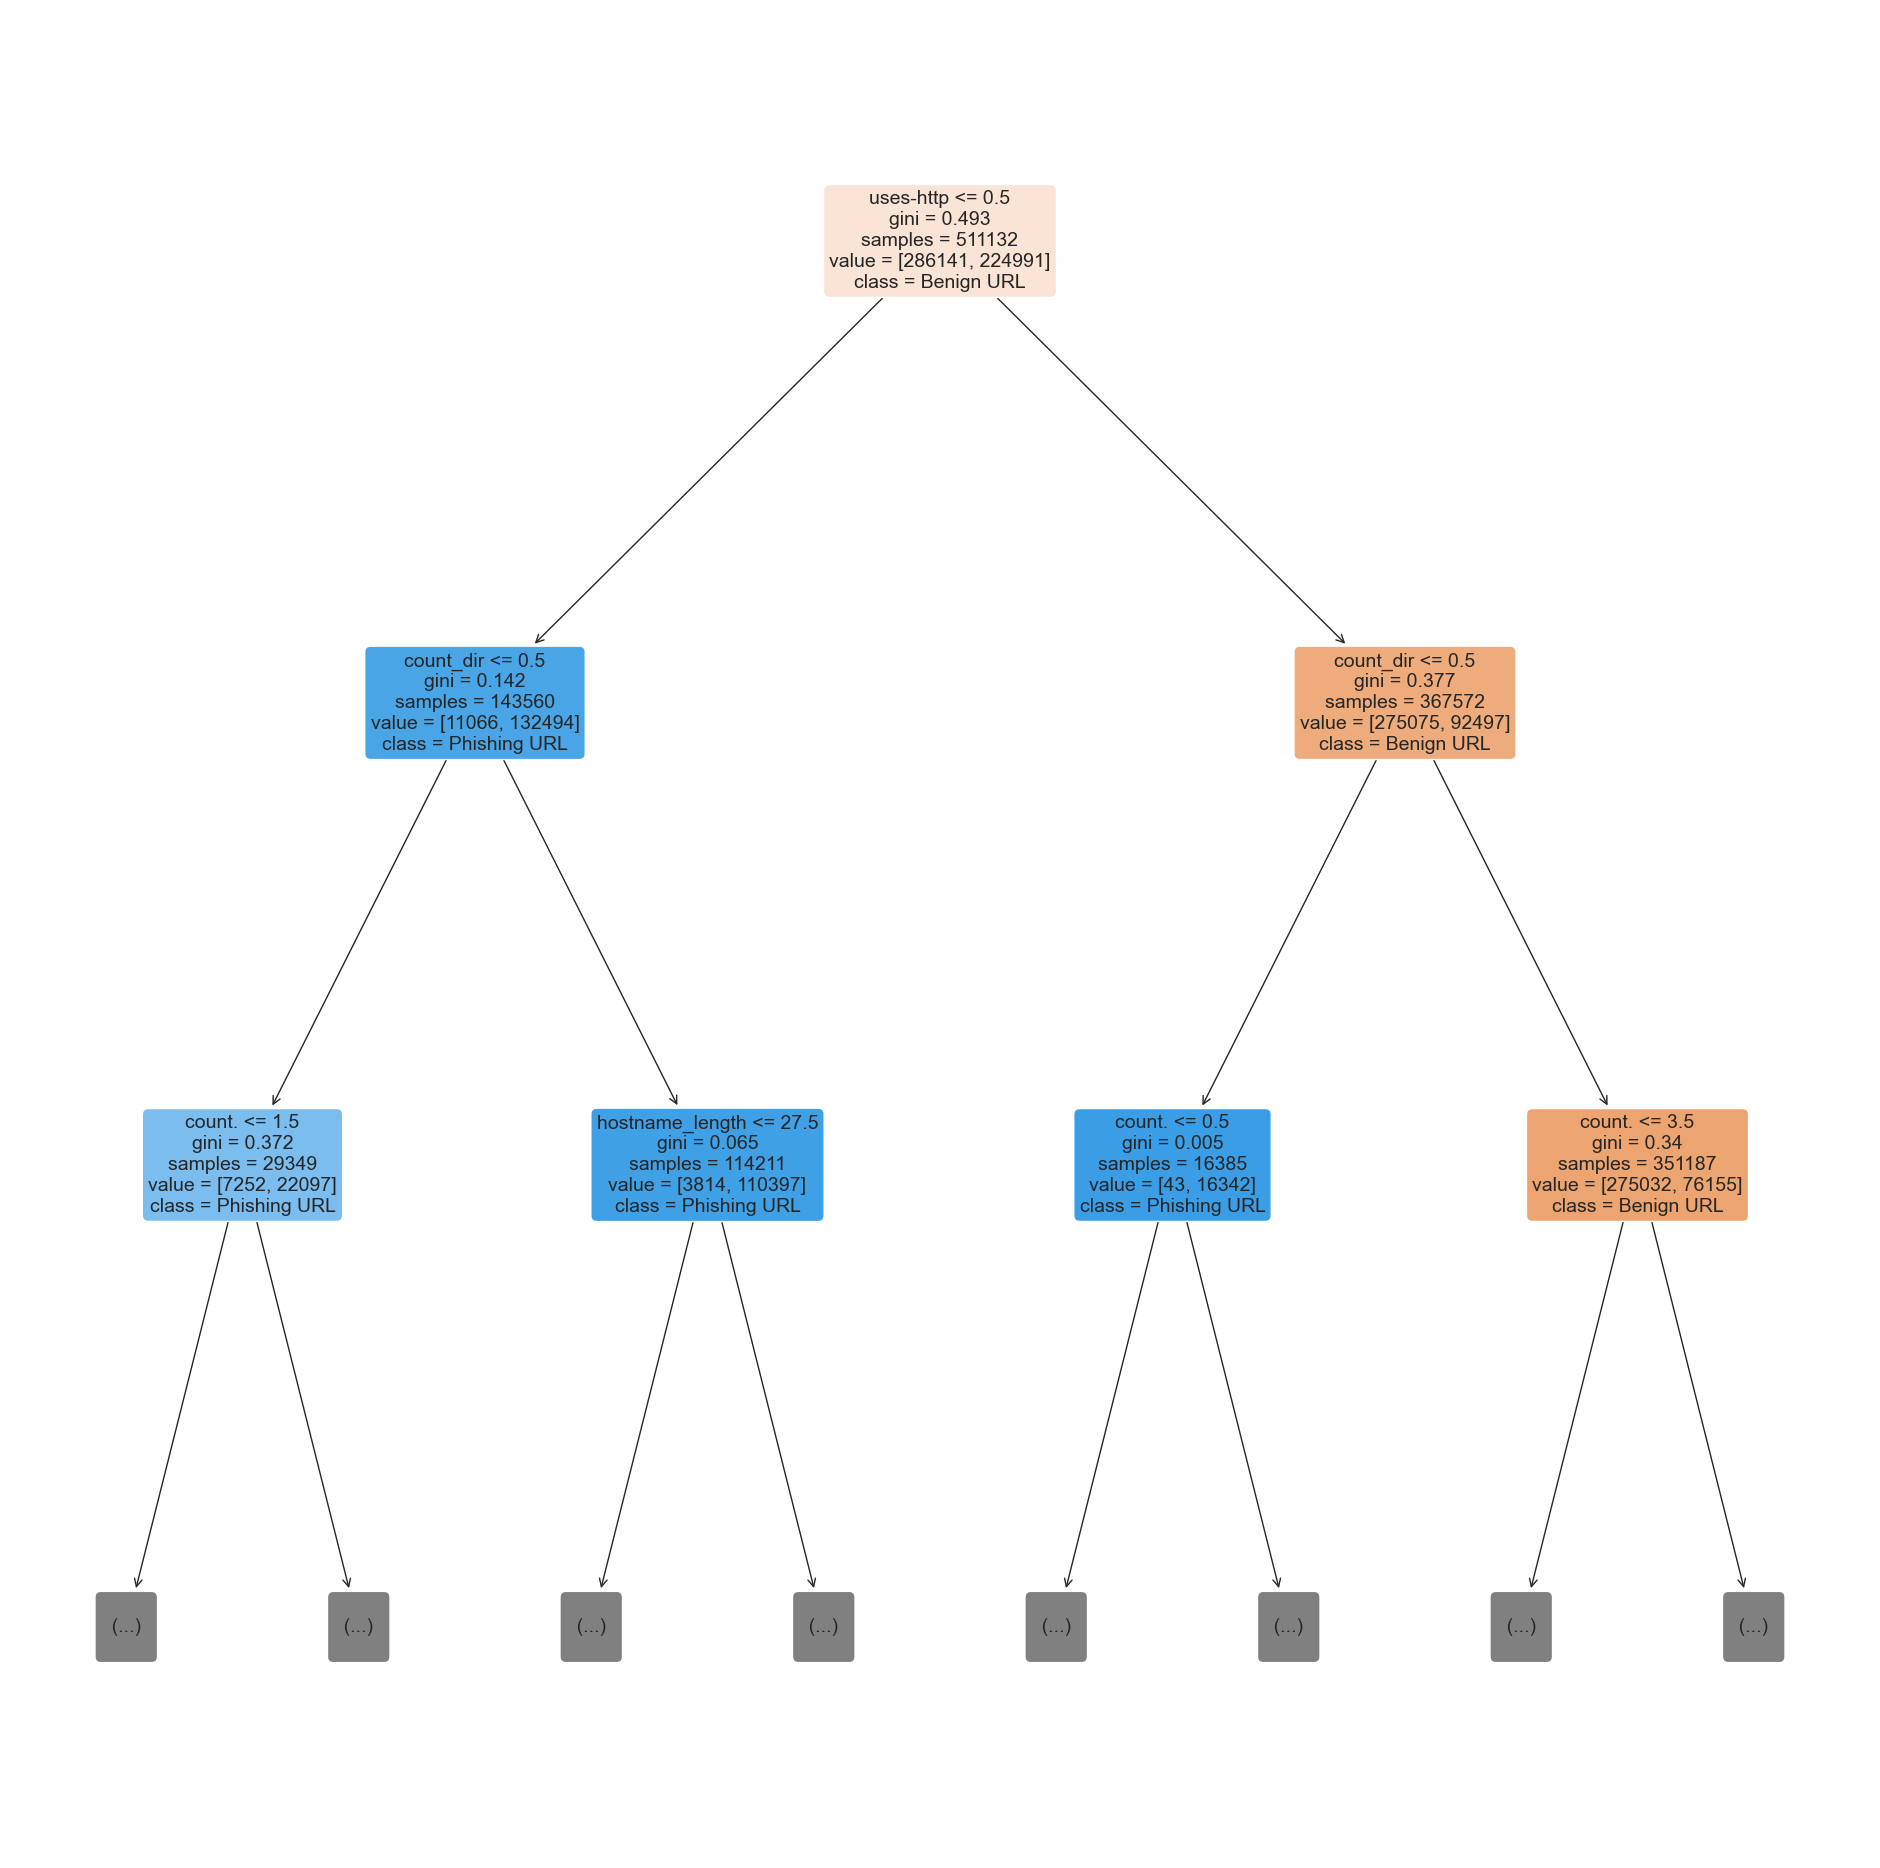

In [12]:
# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, max_depth=2,
          feature_names=X_train.columns, 
          class_names=["Benign URL","Phishing URL"])

### Confusion Matrix

Train Data
Accuracy  :	 0.8549513628573441

TPR Train :	 0.7265712850736251
TNR Train :	 0.9558958695188735

FPR Train :	 0.044104130481126436
FNR Train :	 0.2734287149263748


<AxesSubplot:>

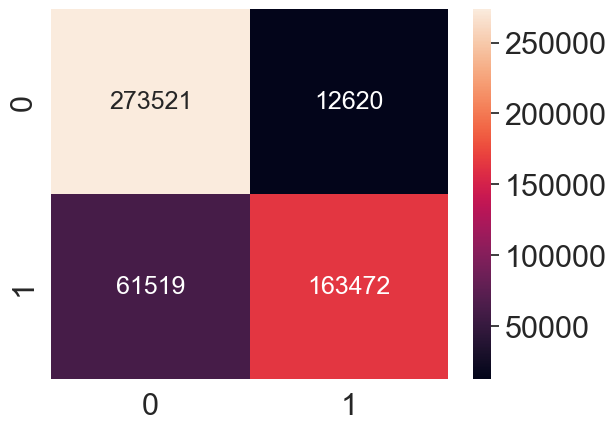

In [13]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8564163665164775

TPR Test :	 0.7288502355438216
TNR Test :	 0.9570187471422039

FPR Test :	 0.04298125285779607
FNR Test :	 0.2711497644561785


<AxesSubplot:>

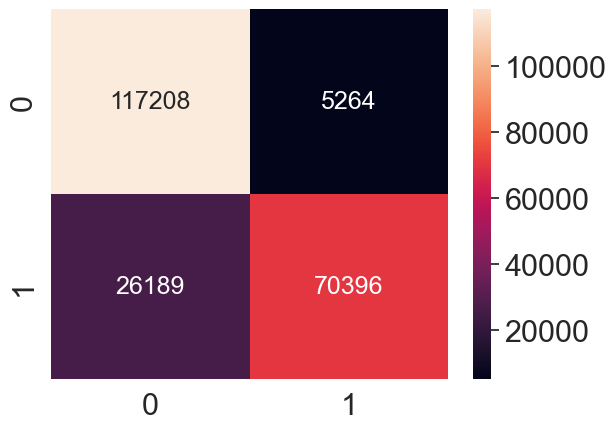

In [14]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [15]:
# Print classification report
cr = classification_report(y_test, y_test_pred)
print(cr)

              precision    recall  f1-score   support

      benign       0.82      0.96      0.88    122472
    phishing       0.93      0.73      0.82     96585

    accuracy                           0.86    219057
   macro avg       0.87      0.84      0.85    219057
weighted avg       0.87      0.86      0.85    219057



### 3. Attempt 1: Decision Tree Conclusion
While the decision tree yields a seemingly decent accuracy of 0.8559, in the context of cybersecurity, this means that a significant number of phishing URLs might be misidentified as benign. We should aim to push our accuracy higher with other models.

### 4. Attempt 2: Random Forest Classifier

In [16]:
# Extract Response and Predictors
y = pd.DataFrame(df_final['phish'])
X = pd.DataFrame(df_final.drop('phish', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [17]:
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree

### Stratified k-fold verification for random forest classifier

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
cv_results = cross_val_score(rforest, X_train, y_train['phish'], cv=skf)

In [19]:
cv_results, cv_results.mean()

(array([0.85378618, 0.85663279, 0.85470428, 0.85388257, 0.85571185]),
 0.8549435360495968)

### Fitting data into forest

In [20]:
# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.phish.ravel())

RandomForestClassifier(max_depth=4)

### Random Forest Model Evaluation

Train Data
Accuracy  :	 0.8542861726520742

TPR Train :	 0.7283663880771998
TNR Train :	 0.9534464067144606

FPR Train :	 0.04655359328553943
FNR Train :	 0.2716336119228002


<AxesSubplot:>

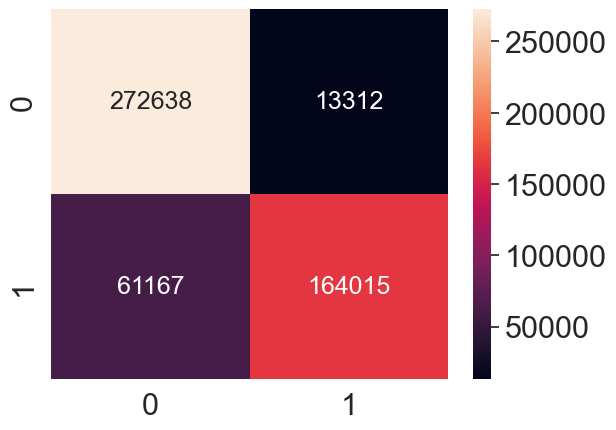

In [21]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.8545355774980941

TPR Test :	 0.7283129655372741
TNR Test :	 0.9537268777055836

FPR Test :	 0.04627312229441641
FNR Test :	 0.2716870344627259


<AxesSubplot:>

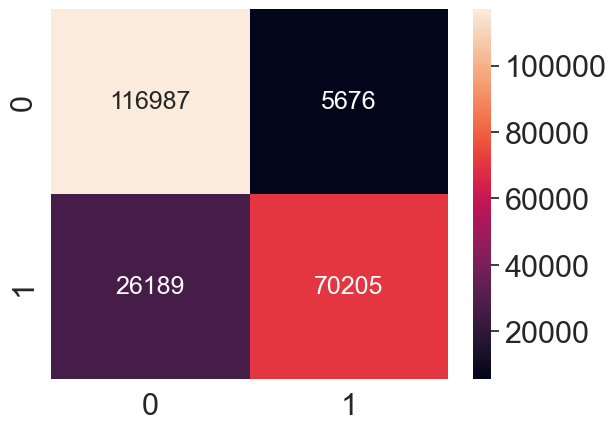

In [22]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [23]:
# Print classification report
cr = classification_report(y_test, y_test_pred)
print(cr)

              precision    recall  f1-score   support

      benign       0.82      0.95      0.88    122663
    phishing       0.93      0.73      0.82     96394

    accuracy                           0.85    219057
   macro avg       0.87      0.84      0.85    219057
weighted avg       0.86      0.85      0.85    219057



### 5. Parameter tuning using Cross-Validation(Randomized Search)

In [24]:
# Extract Response and Predictors
y = pd.DataFrame(df_final['phish'])
X = pd.DataFrame(df_final.drop('phish', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [25]:
# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_dist = {'max_depth': np.arange(2, 11),
              'min_samples_split': [2,6,10],
              'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)],
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}

# Create the Hyper-parameter Grid
random_search = RandomizedSearchCV(RandomForestClassifier(),   # the model family
                                   param_distributions=param_dist,                 # the search grid
                                   cv = 5,                     # 5-fold cross-validation
                                   n_jobs = -1,
                                   verbose = 3,
                                   scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
random_search.fit(X_train, y_train.phish.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19,
                                                         20]},
                   scoring='accuracy', verbose=3)

In [26]:
# Fetch the best Model or the best set of Hyper-parameters
print(random_search.best_estimator_)

print(random_search.best_params_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(random_search.best_score_))

RandomForestClassifier(max_depth=9, min_samples_split=10, n_estimators=4)
{'n_estimators': 4, 'min_samples_split': 10, 'max_depth': 9, 'criterion': 'gini', 'bootstrap': True}
0.8582929653113339


Train Data
Accuracy  :	 0.8585766494760649

TPR Train :	 0.722355774571534
TNR Train :	 0.9657339601866578

FPR Train :	 0.03426603981334219
FNR Train :	 0.27764422542846606


<AxesSubplot:>

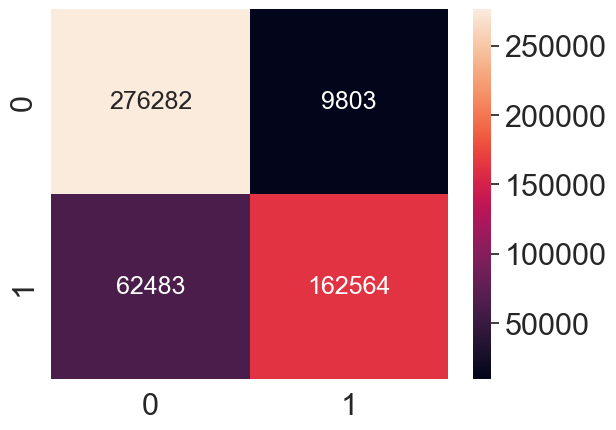

In [27]:
rforest = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       min_samples_split=2, n_estimators=13)
rforest.fit(X_train, y_train.phish.ravel())

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})


Test Data
Accuracy  :	 0.8590138639714777

TPR Test :	 0.7234199048990458
TNR Test :	 0.9658363802559415

FPR Test :	 0.0341636197440585
FNR Test :	 0.2765800951009541


<AxesSubplot:>

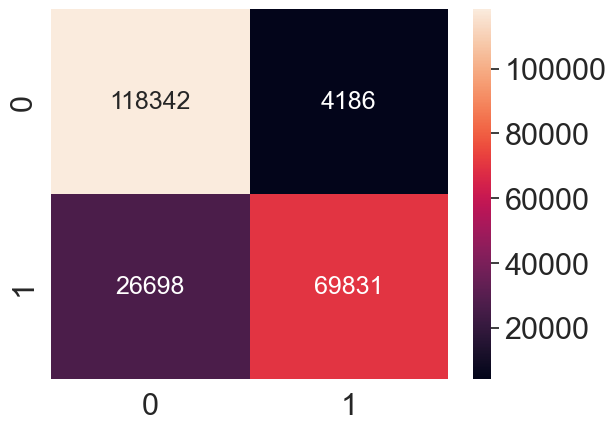

In [28]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### 6. Attempt 2: Random Forest Conclusion

Random Forest with Cross Validation had an increase in accuracy over our final Decision Tree model.